In [1]:
#Add identifier for developing countries, i.e. G20 or OECD


In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
#matplotlib.use('Agg')
from merge_data import merge_data
import numpy as np
import pandas as pd
import os
from config import (census_key, gkey)
import gmaps


In [2]:
#os.chdir('C://Users//adam//Desktop//dagger')

In [3]:
#import, clean and format HI data
hdi_file = 'data/Human Development Index (HDI).csv'
hdi_df = pd.read_csv(hdi_file, encoding = "ISO-8859-1", skiprows=1)
columns = ["Country"]

for i in range(1990, 2018):
   columns = columns + [str(i)]

hdi_df = hdi_df[columns]
hdi_df = hdi_df.melt(id_vars='Country', var_name='Year', value_name="HDI")
hdi_df = hdi_df.dropna()
hdi_df['Country'] = hdi_df['Country'].str.strip()
#hdi_df.head()

In [4]:
#import and clean the power data
power_file = 'data/global_power_plant_database.csv'
power_df = pd.read_csv(power_file)
power_df['commissioning_year'] = round(power_df['commissioning_year'],0)
power_df = power_df[power_df['commissioning_year']>=1990]
#power_df.head()

In [5]:
#importing, cleaning, and formatting the population data
pop_file = ('data/API_SP.POP.TOTL_DS2_en_csv_v2_103676.csv')
pop_df = pd.read_csv(pop_file, encoding = "ISO-8859-1", skiprows=4)
pop_df = pop_df.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)
pop_df = pop_df.melt(id_vars='Country Name', var_name='Year', value_name='Population')
pop_df = pop_df.rename(columns={'Country Name':'Country'})
#pop_df.head()

In [6]:
#filter power df and create df for cumulative capacity
pow_pd = power_df[['country_long', 'capacity_mw', 'commissioning_year' ]]
pow_pd.head(20)
country_list = pow_pd['country_long'].unique()

cap_data = pd.DataFrame(columns = ['country_long', 'commissioning_year'])

for i in range(len(country_list)):
    for year in range(1990, 2018):
        cap_data.loc[i*37 + year-1990] = [country_list[i], year]    

# Aggregate capacity when same country and year
countries = pow_pd.groupby(['country_long', 'commissioning_year'])
cap_added = countries['capacity_mw'].sum()

In [7]:
# merge data agreggate capacity with counrty year df
cap_cont_yr = pd.merge(cap_data, cap_added, on=['country_long', 'commissioning_year'], how='left')
cap_cont_yr = cap_cont_yr.fillna(0)

In [8]:
# create cumulative cap by country and year
cap_cont_yr['commissioning_year'] = cap_cont_yr['commissioning_year'].astype(str)
cap_sum = cap_cont_yr.groupby(by=['country_long', 'commissioning_year']).sum().groupby(level=[0])
cap_cum = cap_cont_yr.groupby(by=['country_long', 'commissioning_year']).sum().groupby(level=[0]).cumsum()

In [9]:
# merge hdi, pop, and capacity by Country and Year
hdi_pop_merged = pd.merge(hdi_df, pop_df, on=['Country', 'Year'])
merged_data = pd.merge(hdi_pop_merged, cap_cum, left_on=['Country', 'Year'], right_on=['country_long', 'commissioning_year'])

In [10]:
# Capacity is based on added capacity beginning using end of 1989 as baseline.  Does not include losses in capacity.

merged_data.head()
# merged_data[merged_data['Country']=='China']
    

,Country,Year,HDI,Population,capacity_mw
0,Algeria,1990,0.577,25758869.0,0.00
1,Argentina,1990,0.704,32618651.0,761.02
2,Armenia,1990,0.631,3538171.0,0.00
3,Austria,1990,0.795,7677850.0,13.00
4,Bahrain,1990,0.746,495931.0,0.00


In [12]:
merged_data['HDI'].corr(merged_data['capacity_mw'])

0.01896294672060638

In [13]:
merged_data['Population'].corr(merged_data['capacity_mw'])

0.6651227892089613

In [14]:
country_df = merged_data[merged_data['Country']=='Japan']
country_df['Population'].corr(country_df['capacity_mw'])

0.9281685266987779

In [15]:
country_df['HDI'].corr(country_df['capacity_mw'])

0.9487733933503127

In [16]:
corr_data = pd.DataFrame(columns=['Country', 'HDI-cap corr', 'Pop-cap corr', 'HDI-pop corr'])


In [17]:
country_df.corr()

,HDI,Population,capacity_mw
HDI,1.000000,0.800259,0.948773
Population,0.800259,1.000000,0.928169
capacity_mw,0.948773,0.928169,1.000000


In [18]:
for i in range(len(country_list)):
    country = country_list[i]
    country_df = merged_data[merged_data['Country']==country]
    hdi_cap = country_df['HDI'].corr(country_df['capacity_mw'])
    pop_cap = country_df['Population'].corr(country_df['capacity_mw'])
    hdi_pop = country_df['HDI'].corr(country_df['Population'])
    corr_data.loc[i] = [country, hdi_cap, pop_cap, hdi_pop]
    
#corr_data.head(10)    

In [11]:
def animate(i):
    x.append(xs[i])
    y.append(ys[i])
    s.append(ss[i]/1000)
    sc.set_offsets(np.c_[x,y])
    sc.set_sizes(s)
    ax.legend(grf_data['Country'] + " " + x[i] + " capacity " + str(s[i]) + "Mw")

In [ ]:
for c in set(merged_data['Country']):
    grf_data = merged_data[merged_data['Country']==c].reset_index()

    fig, ax = plt.subplots()
    x,y,s  = [],[],[]
    sc = ax.scatter(x,y,s=s)
    plt.xlim(1990,2020)
    plt.ylim(0.25,1)

    xs = grf_data['Year']
    ys = grf_data['HDI']
    ss = grf_data['capacity_mw']
    ani = FuncAnimation(fig, animate, interval=100, repeat=True) 
    try:
        ani.save('output/'+c+'.gif', writer='pillow')
    except:
        pass
    

    
#anim_setup('Year','HDI','capacity_mw')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


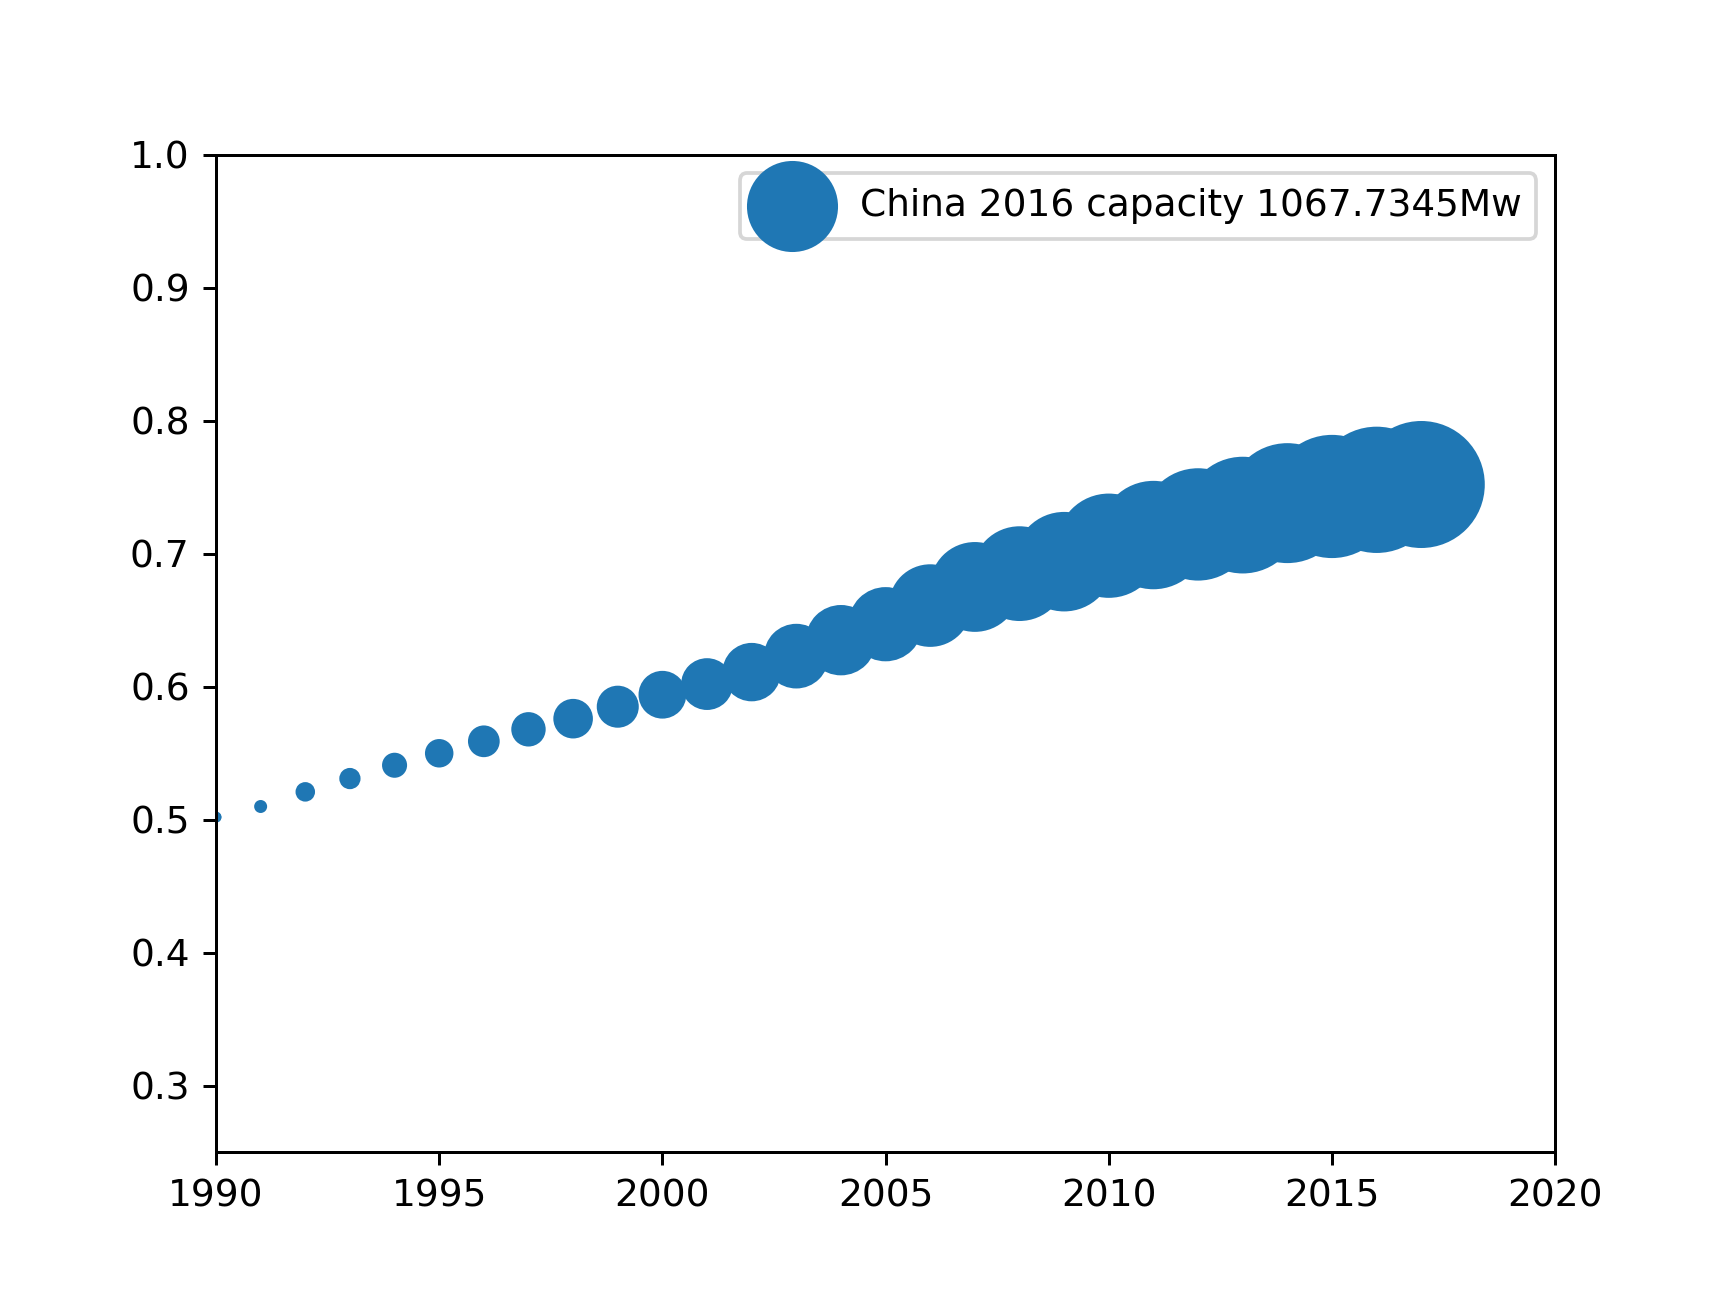

In [12]:
grf_data = merged_data[merged_data['Country']=='China'].reset_index()

fig, ax = plt.subplots()
x,y,s  = [],[],[]
sc = ax.scatter(x,y,s=s)
plt.xlim(1990,2020)
plt.ylim(0.25,1)

xs = grf_data['Year']
ys = grf_data['HDI']
ss = grf_data['capacity_mw']
ani = FuncAnimation(fig, animate, interval=100, repeat=True) 